In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from rl_es.setting import ENVIRONMENTS
from cd_diag import draw_cd_diagram


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [2]:
correct_envs = ['Acrobot-v1',
    'Ant-v4',
    'Atlantis-v5',
    'BeamRider-v5',
    'BipedalWalker-v3',
    'Boxing-v5',
    'CartPole-v1',
    'CrazyClimber-v5',
    'Enduro-v5',
    'HalfCheetah-v4',
    'Hopper-v4',
    'Humanoid-v4',
    'LunarLander-v2',
    'Pendulum-v1',
    'Pong-v5',
    'Qbert-v5',
    'Seaquest-v5',
    'SpaceInvaders-v5',
    'Swimmer-v4']

max_timesteps = dict(
        (("Acrobot-v1", 5e5),
        ("Pendulum-v1", 5e5),
        ("BipedalWalker-v3", 2e6),
        ("Hopper-v4", 1e6),
        ("Walker2d-v4", 2e6),
        ("Ant-v4", 1e7),
        ("Humanoid-v4", 1e7),
        ("Atlantis-v5", 2e7),
        ("BeamRider-v5", 2e7),
        ("Pong-v5", 2e7),
        ("CrazyClimber-v5", 2e7),
        ("Enduro-v5",  2e7),
        ("Qbert-v5", 2e7),
        ("Seaquest-v5", 2e7),
        ("CartPole-v1", 5e5),
        ("LunarLander-v2", 5e5),
        ("Swimmer-v4", 5e5),
        ("HalfCheetah-v4", 3e6),
        ("Boxing-v5", 2e7),
        ("SpaceInvaders-v5", 2e7)
    ))

def get_all_data(data_file='../fixed_data/all_data.pkl'):
    if os.path.exists(data_file):
        return pd.read_pickle(data_file)

    rl_data = pd.read_pickle(f"../fixed_data/rl_data3.pkl")
    data = pd.DataFrame()
    for f in os.listdir('../data'):
        f = os.path.join("../data", f)
        if not(os.path.isdir(f) and '-' in f):
            continue
        if f.count("-") == 2:
            continue
        
        try: 
            env_data = pd.read_pickle(f"{f}/data_hyp.pkl")
        except:
            env_data = pd.read_pickle(f"{f}/data.pkl")
        env_data['env'] = os.path.basename(f)
        data = pd.concat([data, env_data])
        print(f)
    all_data = pd.concat([rl_data, data])[["env", "method", "run", "n_train_timesteps", "test"]]
    all_data.loc[all_data.method == 'ars', "method"] = 'ars-v1'
    all_data.to_pickle(data_file)
    return all_data

def get_filtered_data(data_file="../fixed_data/limited_data.pkl"):
    if os.path.exists(data_file):
        return pd.read_pickle(data_file)
 

    limited_data = all_data[all_data.env.isin(correct_envs)]

    for k, v in max_timesteps.items():
        mask = (limited_data['env'] == k) & (limited_data['n_train_timesteps'] > v)
        limited_data = limited_data[~mask].reset_index(drop=True)

    limited_data.to_pickle(data_file)
    return limited_data

limited_data = get_filtered_data()

In [3]:
summary = limited_data.groupby(['env', 'method', 'run'])['test'].max().groupby(['env', 'method']).describe()
summary.reset_index(inplace=True)
summary

,env,method,count,mean,std,min,25%,50%,75%,max
0,Acrobot-v1,ars-v1,5.0,-69.800000,2.949576,-72.500000,-72.500000,-70.000000,-68.500000,-65.500000
1,Acrobot-v1,ars-v2,5.0,-69.700000,0.908295,-71.000000,-70.000000,-69.500000,-69.500000,-68.500000
2,Acrobot-v1,cma-es,10.0,-73.150000,6.169144,-84.000000,-76.750000,-70.250000,-69.250000,-65.000000
3,Acrobot-v1,csa,10.0,-75.200000,2.496664,-80.500000,-75.500000,-74.750000,-74.000000,-71.500000
4,Acrobot-v1,dqn_large,10.0,-65.100000,3.238655,-69.000000,-67.875000,-65.500000,-62.000000,-61.000000
...,...,...,...,...,...,...,...,...,...,...
139,Swimmer-v4,ppo_large,5.0,63.023762,9.025437,47.713039,63.727974,64.401993,68.764206,70.511597
140,Swimmer-v4,ppo_small,5.0,33.438980,9.175429,19.289803,31.822540,34.499069,37.278069,44.305420
141,Swimmer-v4,sac_large,5.0,50.096323,3.390707,46.303825,48.649597,49.764709,50.246929,55.516552
142,Swimmer-v4,sac_small,7.0,30.609646,3.725200,23.948509,29.461831,32.267380,33.024292,33.079384


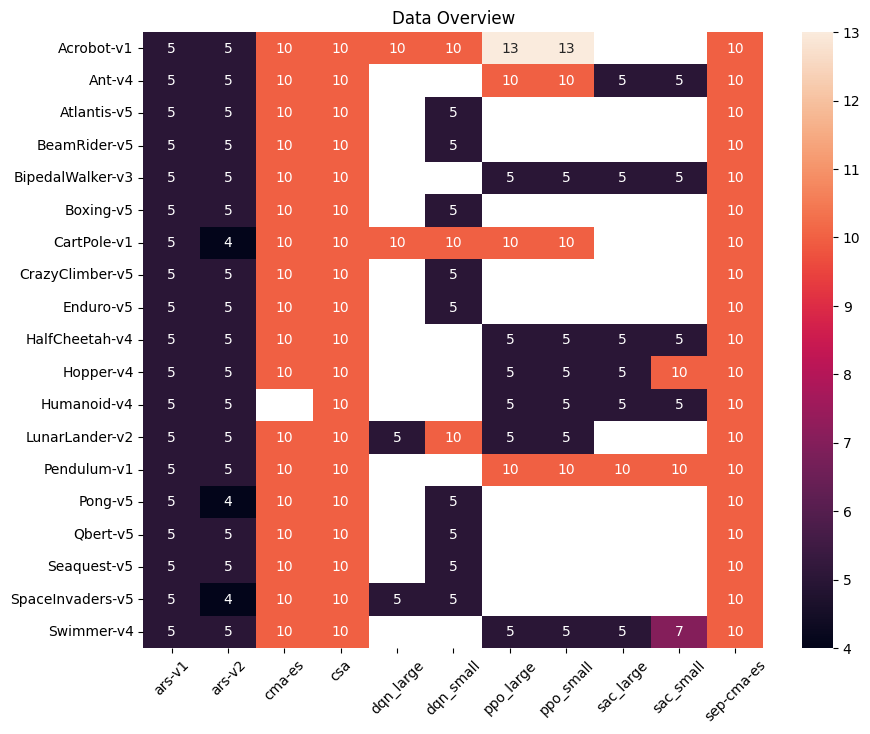

In [4]:
pv = summary[["count", "env", "method"]].pivot(index=['env'], columns=['method'])
plt.figure(figsize=(10, 8))
sns.heatmap(pv, annot=True)
x, labels = plt.xticks()
labels = [l.get_text()[6:] for l in labels]
plt.xticks(x, labels, rotation=45)
plt.xlabel(None)
plt.ylabel(None)
plt.title("Data Overview");

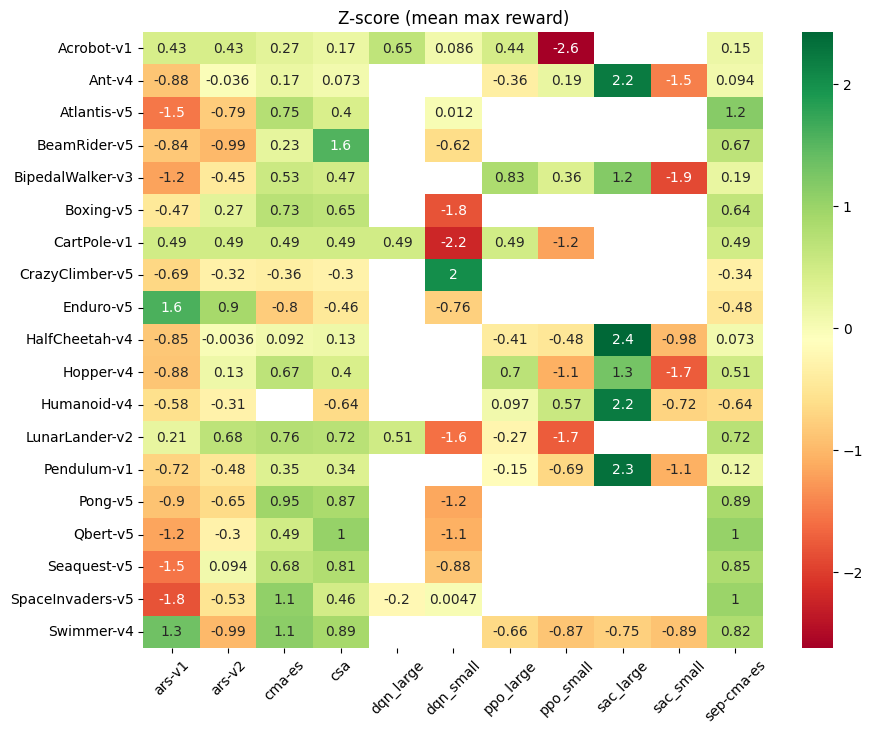

In [5]:
pv = summary[["mean", "env", "method"]].pivot(index=['env'], columns=['method'])
pv = (pv - pv.mean(axis=1).values.reshape(-1, 1)) / pv.std(axis=1).values.reshape(-1, 1)

plt.figure(figsize=(10, 8))
sns.heatmap(pv, annot=True, cmap='RdYlGn')
x, labels = plt.xticks()
labels = [l.get_text()[5:] for l in labels]
plt.xticks(x, labels, rotation=45)
plt.xlabel(None)
plt.ylabel(None)
plt.title("Z-score (mean max reward)");

In [6]:
# pv.iloc[[1, 4, 9, 10, 13, 18]].dropna(axis=1) # Mujoco
pv.iloc[[2, 3, 5, 7, 8, 14, 15, 16, 17]].dropna(axis=1)

mean                                                   
method              ars-v1    ars-v2    cma-es       csa dqn_small sep-cma-es
env                                                                          
Atlantis-v5      -1.523459 -0.791216  0.750587  0.398564  0.011977   1.153548
BeamRider-v5     -0.839792 -0.991888  0.228013  1.555321 -0.623409   0.671755
Boxing-v5        -0.467667  0.273405  0.726683  0.654734 -1.827499   0.640344
CrazyClimber-v5  -0.689459 -0.321306 -0.363774 -0.302364  2.019902  -0.342998
Enduro-v5         1.593544  0.900796 -0.795935 -0.461274 -0.755776  -0.481354
Pong-v5          -0.896880 -0.645124  0.949329  0.865411 -1.159126   0.886390
Qbert-v5         -1.178756 -0.298767  0.485025  1.027908 -1.073358   1.037946
Seaquest-v5      -1.548708  0.094120  0.675955  0.807153 -0.875605   0.847083
SpaceInvaders-v5 -1.816919 -0.528291  1.082662  0.456737  0.004681   0.999740

In [7]:
summary[["mean", "env", "method"]]

,mean,env,method
0,-69.800000,Acrobot-v1,ars-v1
1,-69.700000,Acrobot-v1,ars-v2
2,-73.150000,Acrobot-v1,cma-es
3,-75.200000,Acrobot-v1,csa
4,-65.100000,Acrobot-v1,dqn_large
...,...,...,...
139,63.023762,Swimmer-v4,ppo_large
140,33.438980,Swimmer-v4,ppo_small
141,50.096323,Swimmer-v4,sac_large
142,30.609646,Swimmer-v4,sac_small


In [8]:
from critdd import Diagram
import pandas as pd


In [9]:
ddata = pv.iloc[[2, 3, 5, 7, 8, 14, 15, 16, 17]].dropna(axis=1)

def make_diagram_tikz(ddata):
    return Diagram(
        ddata.values,
        treatment_names = ddata.columns.values.tolist(),
        maximize_outcome = True
    )

# diagram = make_diagram(ddata)
# print(diagram.to_str(alpha=.05, adjustment="holm"))


In [10]:
atari_data = limited_data[limited_data.env.isin(pv.iloc[[2, 3, 5, 7, 8, 14, 15, 16, 17]].index)]
mujoco_data = limited_data[limited_data.env.str.endswith('v4')]

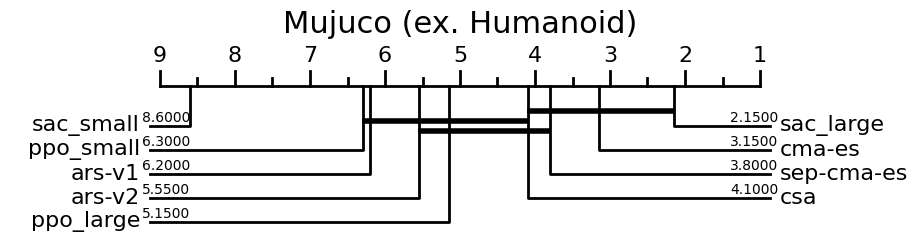

In [11]:
selection = mujoco_data[(mujoco_data.run > 0) & (mujoco_data.run <= 5)].groupby(["method", "env", "run"])['test'].max()
mdata = pd.DataFrame(selection)
mdata.reset_index(inplace=True)
mdata = mdata[mdata.env != "Humanoid-v4"]
mdata['env_run'] = mdata.env + mdata.run.astype(str)
mdata['test_z'] = mdata.groupby("env")['test'].transform(lambda x: (x - x.mean()) / x.std())

draw_cd_diagram(
    mdata, 
    alpha=0.1, 
    title='Mujuco (ex. Humanoid)', 
    labels=True, 
    classifier_name='method', 
    accuracy='test_z', 
    dataset_name='env_run',
    # test='nemenyi',
    # correction='bonferroni'
)

ddata = mdata.pivot(columns='method', index='env_run', values='test_z')

# diagram = Diagram(
#     ddata.values,
#     treatment_names = ddata.columns.values.tolist(),
#     maximize_outcome = True
# )
# print(diagram.to_str(alpha = .05, adjustment = "bonferroni"))


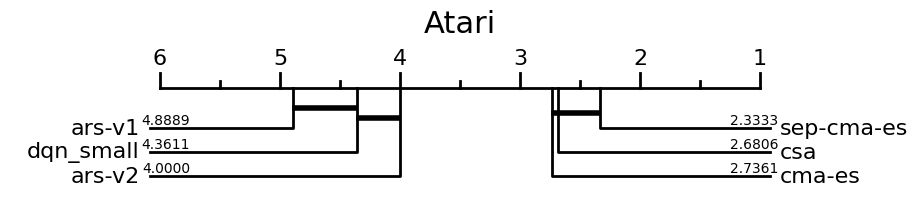

In [12]:
selection = atari_data[(atari_data.run > 0) & (atari_data.run <= 4)].groupby(["method", "env", "run"])['test'].max()
mdata = pd.DataFrame(selection)
mdata.reset_index(inplace=True)

mdata = mdata[mdata.method != 'dqn_large']
mdata['env_run'] = mdata.env + mdata.run.astype(str)
mdata['test_z'] = mdata.groupby("env")['test'].transform(lambda x: (x - x.mean()) / x.std())

draw_cd_diagram(
    mdata, 
    alpha=0.1, 
    title='Atari', 
    labels=True, 
    classifier_name='method', 
    accuracy='test_z', 
    dataset_name='env_run',
)

ddata = mdata.pivot(columns='method', index='env_run', values='test_z')
